1. Memanggil library yang digunakan dalam notebook ini

In [ ]:
import pandas as pd # Untuk membaca data
import matplotlib.pyplot as plt # Visualisasi data
import seaborn as sns # Mempercantik visualisasi data
from sklearn.model_selection import train_test_split # Membagi data latihan menjadi data model dan data validasi
from sklearn.preprocessing import LabelEncoder, StandardScaler # Pra-pemrosesan data sebelum dilatih menjadi model
from sklearn.metrics import accuracy_score, f1_score # Uji metrics yang dilakukan pada model menggunakan data validasi
import xgboost as xgb # Algoritma yang digunakan dalam model

2. Memuat data pelatihan dan data uji menggunakan fungsi pd.read_csv()

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tugas uts/train.csv') # Data untuk pelatihan model
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tugas uts/test.csv') # Data yang akan di prediksi

3. Melakukan pra-pemrosesan data dan rekayasa fitur dengan mengimplementasikan fungsi preprocess_data(df)

In [ ]:
def preprocess_data(df):
    # Mengekstrak grup dan nomor penumpang dari PassengerId
    df[['Group', 'PassengerNo']] = df['PassengerId'].str.split('_', expand=True)

     # Mengekstrak dek, nomor kabin, dan sisi dari Cabin
    df[['Deck', 'CabinNo', 'Side']] = df['Cabin'].str.split('/', expand=True)

     # Mengisi nilai yang hilang
    numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    categorical_features = ['HomePlanet', 'Destination', 'Group', 'Deck', 'Side', 'Name']
    boolean_features = ['CryoSleep', 'VIP']
    for feature in numerical_features:
        df[feature] = df[feature].fillna(df[feature].median())
    for feature in categorical_features:
        df[feature] = df[feature].fillna(df[feature].mode().iloc[0])

    # Melabeli enkode fitur kategorikal
    le = LabelEncoder()
    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])

     # Standarisasi fitur numerik
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # Meng-encode fitur boolean sebagai integer
    for feature in boolean_features:
        df[feature].fillna(False, inplace=True)
        df[feature] = df[feature].astype(int)

    # Menghapus kolom yang tidak perlu
    df.drop(['PassengerId', 'Cabin', 'CabinNo', 'PassengerNo'], axis=1, inplace=True)

    #Mengembalikan dataframe
    return df

# Menerapkan preprocess_data pada
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

4. Membagi data pelatihan menjadi set pelatihan dan validasi menggunakan fungsi train_test_split() dari sklearn

In [ ]:
X = train_data.drop('Transported', axis=1)
y = train_data['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

5. Menentukan parameter-parameter model XGBoost seperti n_estimators, max_depth, learning_rate, subsample, dan colsample_bytree


In [ ]:
params = {
    'n_estimators': 100,#  jumlah pohon keputusan (decision tree) yang akan dibuat dalam model
    'max_depth': 3, # kedalaman maksimum setiap pohon keputusan dalam model
    'learning_rate': 0.01, # seberapa besar bobot yang akan diubah pada setiap iterasi pelatihan
    'subsample': 0.6, # persentase sampel yang akan digunakan pada setiap iterasi pelatihan
    'colsample_bytree': 0.6 # persentase fitur (kolom) yang akan digunakan pada setiap iterasi pelatihan
}

6. Melatih model XGBoost menggunakan fungsi xgb.XGBClassifier() dengan parameter yang telah ditentukan dengan data pelatihan

In [ ]:
model = xgb.XGBClassifier(random_state=42, objective='binary:logistic', n_jobs=-1, eval_metric='auc', **params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

7. Melakukan prediksi pada data validasi menggunakan model yang telah dilatih

In [ ]:
y_pred_val = model.predict(X_val)

In [ ]:
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation F1 score: {val_f1:.4f}')

Validation accuracy: 0.7608
Validation F1 score: 0.7470


In [ ]:
X_test = test_data
y_pred_test = model.predict(X_test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tugas uts/sample_submission.csv')
submission['Transported'] = y_pred_test.astype(bool)
submission.to_csv('submission.csv', index=False)
print('Submission file created.')

Submission file created.


In [ ]:
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation F1 score: {val_f1:.4f}')

Validation accuracy: 0.7608
Validation F1 score: 0.7470


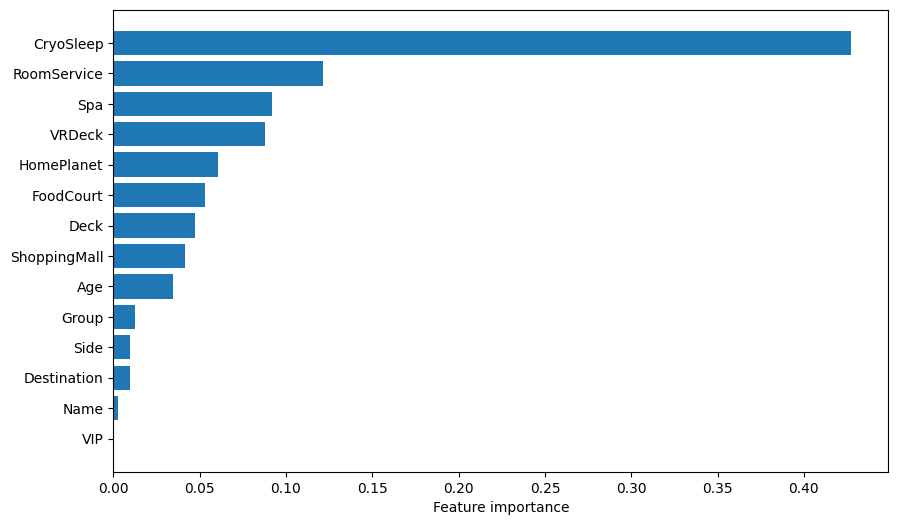

In [ ]:
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature importance')
plt.show()

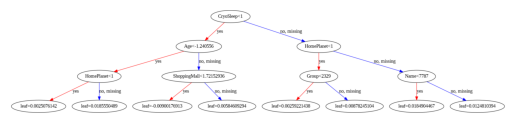

In [ ]:
xgb.plot_tree(model, num_trees=0)
plt.show()

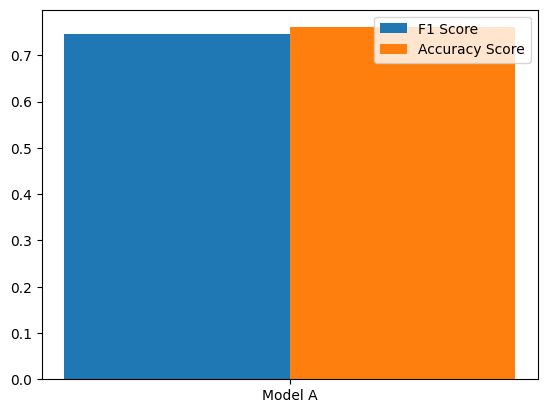

In [ ]:
# f1_score dan accuracy_score adalah nilai f1_score dan accuracy_score dari beberapa model
model_names = ['Model A']
x = range(len(model_names))
plt.bar(x, val_f1, width=0.4, label='F1 Score')
plt.bar([i+0.4 for i in x], val_accuracy, width=0.4, label='Accuracy Score')
plt.xticks([i+0.2 for i in x], model_names)
plt.legend()
plt.show()

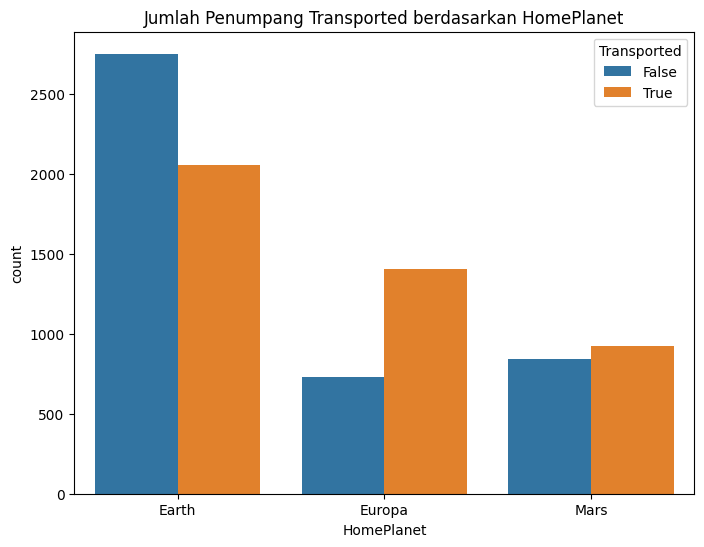

In [ ]:
# Visualisasi HomePlanet
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='HomePlanet', hue='Transported')
plt.title('Jumlah Penumpang Transported berdasarkan HomePlanet')
labels = ['Earth', 'Europa', 'Mars']
plt.xticks(range(len(labels)), labels)
plt.show()

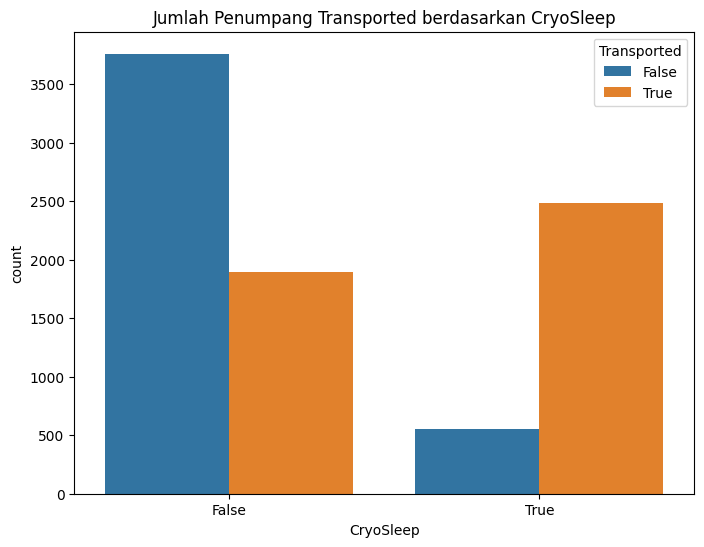

In [21]:
# Visualisasi CryoSleep
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='CryoSleep', hue='Transported')
plt.title('Jumlah Penumpang Transported berdasarkan CryoSleep')
labels = ['False', 'True']
plt.xticks(range(len(labels)), labels)
plt.show()

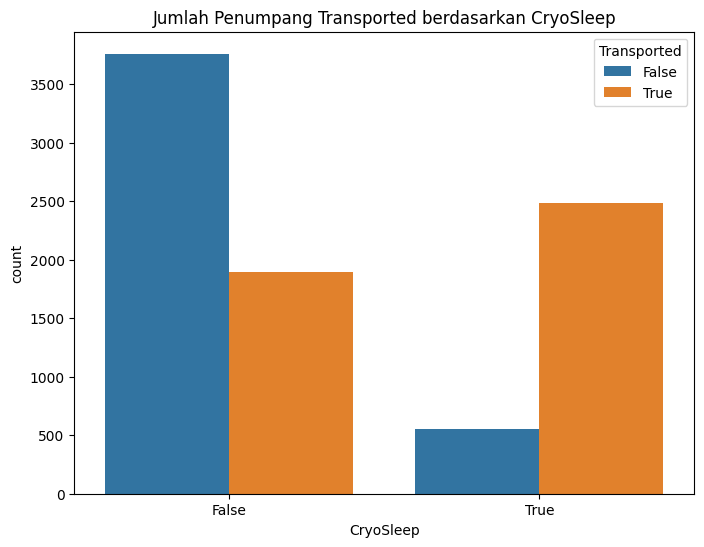

In [22]:
# Visualisasi CryoSleep
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='CryoSleep', hue='Transported')
plt.title('Jumlah Penumpang Transported berdasarkan CryoSleep')
labels = ['False', 'True']
plt.xticks(range(len(labels)), labels)
plt.show()

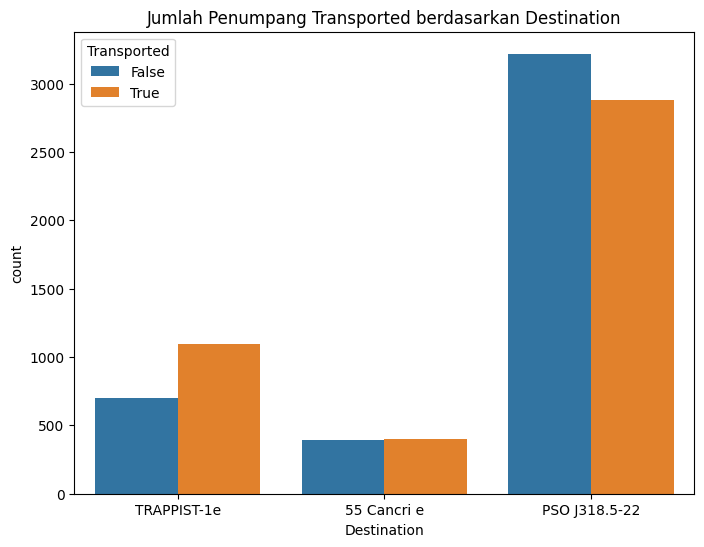

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='Destination', hue='Transported')
plt.title('Jumlah Penumpang Transported berdasarkan Destination')
labels = ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']
plt.xticks(range(len(labels)), labels)
plt.show()

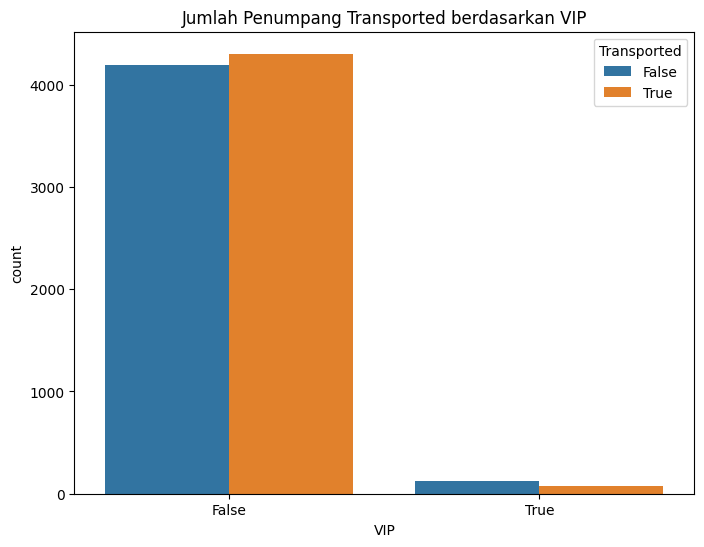

In [24]:
# Visualisasi VIP
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='VIP', hue='Transported')
plt.title('Jumlah Penumpang Transported berdasarkan VIP')
labels = ['False', 'True']
plt.xticks(range(len(labels)), labels)
plt.show()